In [ ]:
%pip install river pandas==2.2.2 scipy==1.13.1 numpy==1.26.1 matplotlib scikit-learn fastdtw

# Teste da SmartWindow

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

from utils.SeriesProcessor import SeriesProcessor
from utils.Visualizer import Visualizer
from classes.smartWindow.Smart_window import SmartWindow

## 1. Preparação dos Dados

In [3]:
# Lista de séries temporais disponíveis (para referência)
series = [
    "AAPL",
    "B3SA3.SA",
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

# Definindo parâmetros para processamento
lags = 5
serie_escolhida = series[-2] # Exemplo: ^BVSP
print(f"Processando série: {serie_escolhida}")

# Baixando os dados
serie_temporal = SeriesProcessor.baixar_dados(serie_escolhida)

# Normalizando a série temporal
serie_temporal_normalizada = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal_normalizada.shape}")

# Gerando janelas temporais (features X e target Y)
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal_normalizada, lags)
print(f"Shape dos dados de entrada (X): {X.shape}")
print(f"Shape dos dados de saída (Y): {Y.shape}")

Processando série: ^BVSP
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Shape da série após normalização: (1244, 1)
Shape dos dados de entrada (X): (1239, 5)
Shape dos dados de saída (Y): (1239, 1)


## 2. Testando a SmartWindow

In [4]:
# Parâmetros da SmartWindow
TAM_JANELA = 50
MAX_JANELAS = 5
LIMIAR_DRIFT = 0.25
LIMIAR_DTW = 2

# Instanciar SmartWindow com RandomForestRegressor
smart_window = SmartWindow(
    tam_janela=TAM_JANELA,
    max_janelas=MAX_JANELAS,
    limiar_drift=LIMIAR_DRIFT,
    limiar_dtw=LIMIAR_DTW,
    modelo=RandomForestRegressor(random_state=42) # Usando RandomForest
)

predicoes = []
drifts_detectados_indices = []
modelo_pronto_para_prever = False

# Iterar sobre os dados ponto a ponto (simulando streaming)
for i in range(len(X)):
    x_i = X[i]
    y_i = Y[i]

    # 1. Fazer predição ANTES de processar/treinar com o ponto atual
    #    (O modelo só pode prever após a primeira janela ser processada)
    y_pred_i = np.nan # Valor padrão caso o modelo ainda não esteja pronto
    if modelo_pronto_para_prever:
        try:
            # Garantir que x_i seja 2D para o predict do scikit-learn
            x_i_reshaped = np.array(x_i).reshape(1, -1)
            y_pred_i = smart_window.modelo.predict(x_i_reshaped)[0]
        except Exception as e:
            print(f"Erro na predição no índice {i}: {e}")
            # Mantém y_pred_i como NaN

    predicoes.append(y_pred_i)

    # 2. Processar o ponto atual com a SmartWindow (adicionar à janela, treinar, detectar drift)
    drift_detectado = smart_window.processar_ponto(x_i, y_i)

    # Marcar se o modelo foi treinado pela primeira vez e está pronto para prever
    if not modelo_pronto_para_prever and len(smart_window.janelas) > 0 and smart_window.modelo is not None:
         modelo_pronto_para_prever = True

    # Registrar drift, se detectado
    if drift_detectado:
        drifts_detectados_indices.append(i)
        print(f"Drift detectado no índice: {i}")

# Converter predições para array numpy
predicoes = np.array(predicoes)

# Calcular MAE e Desvio Padrão (ignorando NaNs iniciais onde o modelo não previu)
mask = ~np.isnan(predicoes) # Máscara para selecionar predições válidas
if np.any(mask):
    y_true_masked = Y[mask].ravel() # Garante que Y seja 1D
    predicoes_masked = predicoes[mask]
    # Verificar se os tamanhos correspondem após aplicar a máscara
    if len(y_true_masked) == len(predicoes_masked):
        erros_absolutos = np.abs(y_true_masked - predicoes_masked)
        mae = np.mean(erros_absolutos)
        std_dev_erro = np.std(erros_absolutos)
        print(f"\nMAE Final (sobre predições válidas): {mae:.4f}")
        print(f"Desvio Padrão do Erro Absoluto: {std_dev_erro:.4f}")
    else:
        print(f"\nAviso: Discrepância de tamanho ao calcular métricas. Y mask: {len(y_true_masked)}, Pred mask: {len(predicoes_masked)}")
else:
    print("\nNão foi possível calcular MAE/StdDev (nenhuma predição válida foi feita).")

print(f"Total de drifts detectados: {len(drifts_detectados_indices)}")

Drift detectado no índice: 145
Drift detectado no índice: 171
Drift detectado no índice: 276
Drift detectado no índice: 372
Drift detectado no índice: 421
Drift detectado no índice: 453
Drift detectado no índice: 499
Drift detectado no índice: 539
Drift detectado no índice: 810
Drift detectado no índice: 891
Drift detectado no índice: 934

MAE Final (sobre predições válidas): 0.2123
Desvio Padrão do Erro Absoluto: 0.1758
Total de drifts detectados: 11


## 3. Visualização dos Resultados


Drift detectado para SmartWindow nos índices: [145, 171, 276, 372, 421, 453, 499, 539, 810, 891, 934]


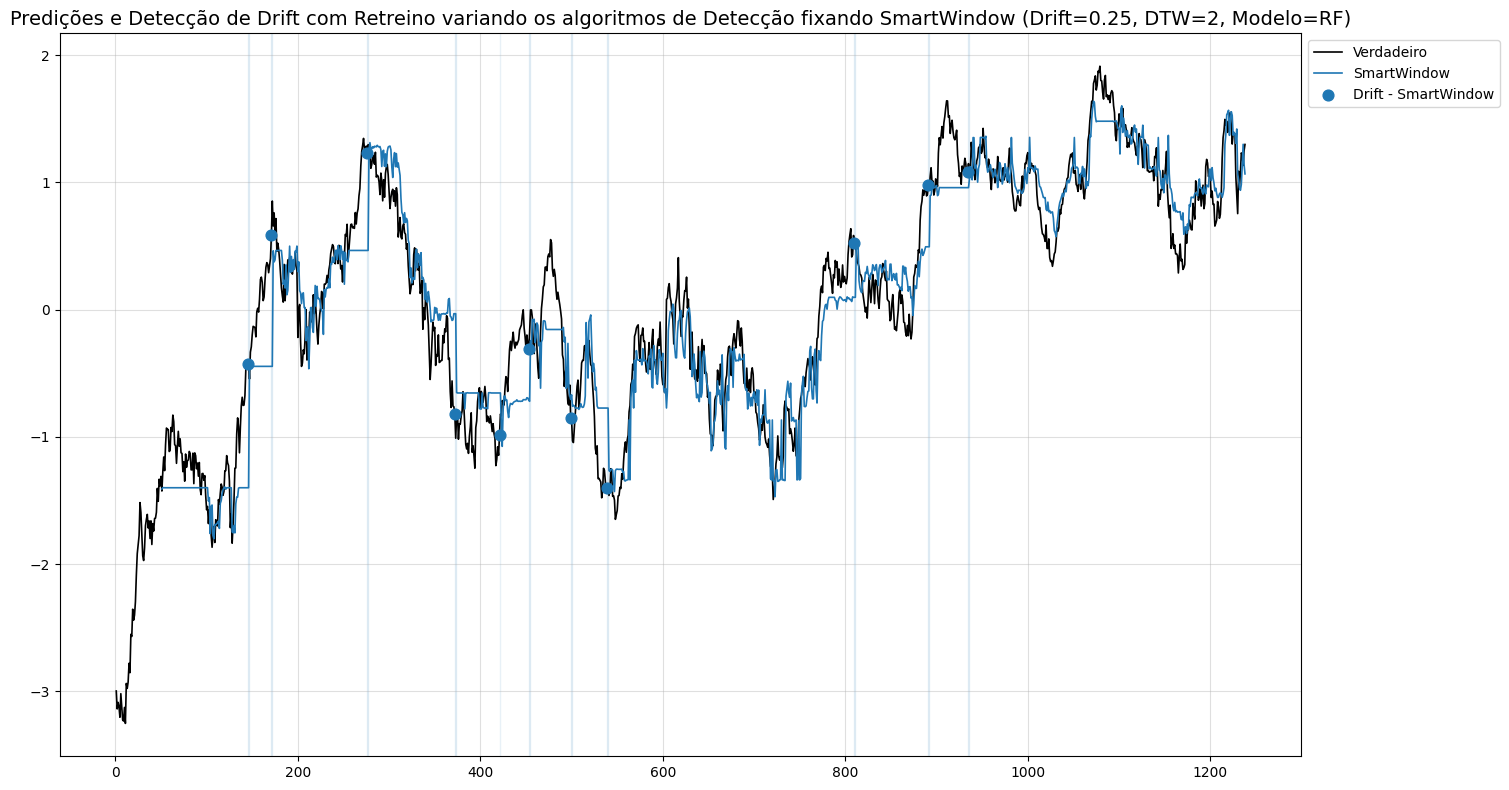

In [6]:
# Preparar dados para visualização
resultados_dict = {'SmartWindow': predicoes}
deteccoes_dict = {'SmartWindow': drifts_detectados_indices}

# Plotar os resultados usando a classe Visualizer
Visualizer.plotar_resultados_multi(
    Y, # Valores reais (target)
    list(resultados_dict.values()), # Lista contendo o array de predições
    list(resultados_dict.keys()), # Lista com o nome do método ('SmartWindow')
    deteccoes_dict, # Dicionário com os índices de drift detectados
    tamanho_batch=1, # Processamento ponto a ponto
    detector_or_modelo=f"SmartWindow (Drift={LIMIAR_DRIFT}, DTW={LIMIAR_DTW}, Modelo=RF)" # Título do gráfico
)